# MCMC Model Visual Diagnostics

In this tutorial, we want to demonstrate how to use the plotting utilities to diagnose Orbit MCMC models. Those could be very useful in practice when checking the convergence of MCMC.

In [1]:
import pandas as pd
import numpy as np
from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull
from orbit.diagnostics.plot import plot_posterior_params
from orbit.utils.dataset import load_iclaims

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

## Data - Initial Claim

First, let's load the example data set. Here we used weekly initial claims data from U.S. Employment and Training Administration. An initial claim is a claim filed by an unemployed individual after a separation from an employer. The claim requests a determination of basic eligibility for the Unemployment Insurance program. 

The dataset has 5 colums: 'week', 'claims', 'trend.unemploy', 'trend.filling' and 'trend.job'.

U.S. Employment and Training Administration, Initial Claims [ICNSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/ICNSA, January 3, 2021.

In [2]:
df = load_iclaims()
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    np.log(df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']])

In [3]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


array([<matplotlib.axes._subplots.AxesSubplot object at 0x131785048>,
      dtype=object)

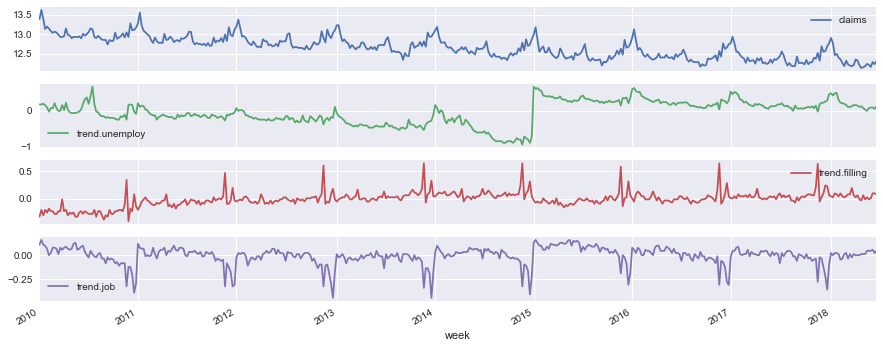

In [4]:
df_tmp = df.copy()
df_tmp.set_index('week', inplace = True) 
df_tmp.plot(subplots=True, figsize=(15,6))

Spliting the data into train and test. We use the last 52 weeks as test df. 

In [5]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## Fit a Model

Before we show the diagnostic tool, we will fit a DLT model with claims data. There are three regressors: 'unemploy', 'filling' and 'job'. We set `seasaonlity = '52'`. 

In [6]:
DATE_COL="week"
RESPONSE_COL="claims"
REGRESSOR_COL=['trend.unemploy', 'trend.filling', 'trend.job']

In [7]:
dlt_mcmc = DLTFull(
    response_col=RESPONSE_COL,
    date_col=DATE_COL,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '='], 
    seasonality=52,
)

## Posterior Diagnostic Viz

In [8]:
dlt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### density/histogram

By setting `kind = 'density'`, we get posterior paramter density plot. It shows the mean, median and Confidence Interval (95% by default)

If you see certain warning message related to `scipy`, which can be resolved by upgrading to `scipy>=1.2` for python >= 3.6.

You can specify a path string (e.g., './density.png') to save the chart.

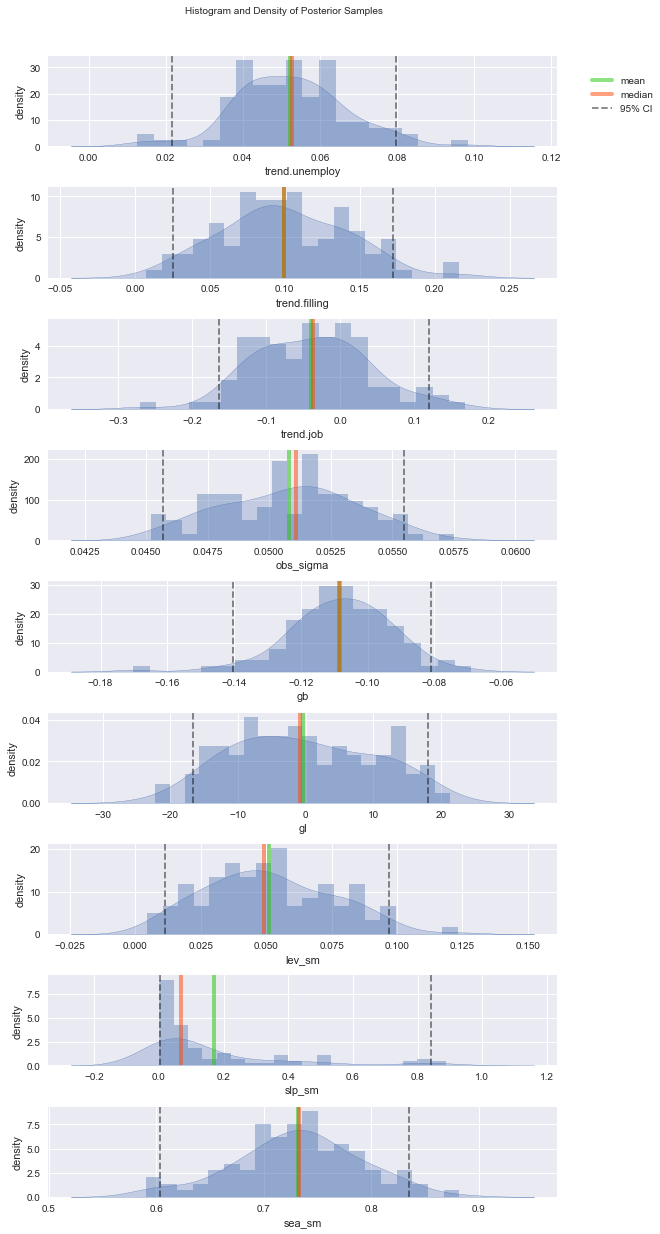

In [9]:
_ = plot_posterior_params(dlt_mcmc, kind='density',
                          incl_trend_params=True, incl_smooth_params=True)

### trace

trace plot shows the iterations of each paramter over the Markov chain. 
Currently, trace plot may not represent the actual sample process for different chainse since this information is not stored in orbit model objects.

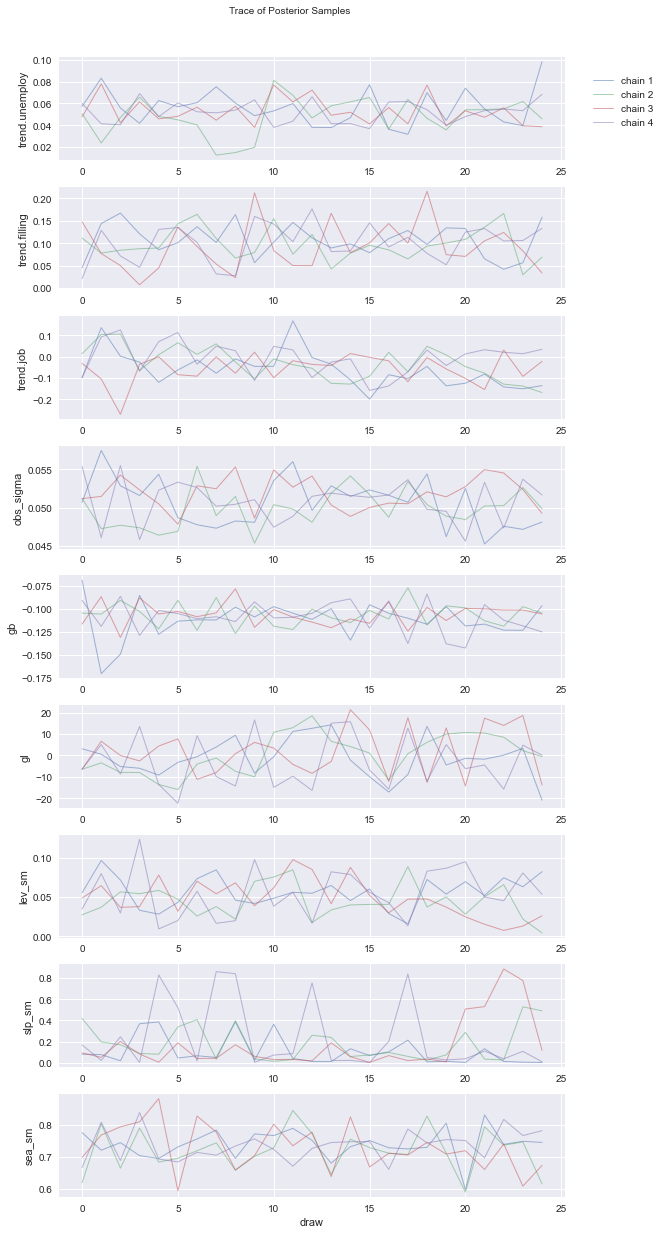

In [10]:
_ = plot_posterior_params(dlt_mcmc, kind='trace',
                          incl_trend_params=True, incl_smooth_params=True)

### pair plot
Setting `kind = 'pair'` will generates a pair plot, which gives us the relationship between parameters.

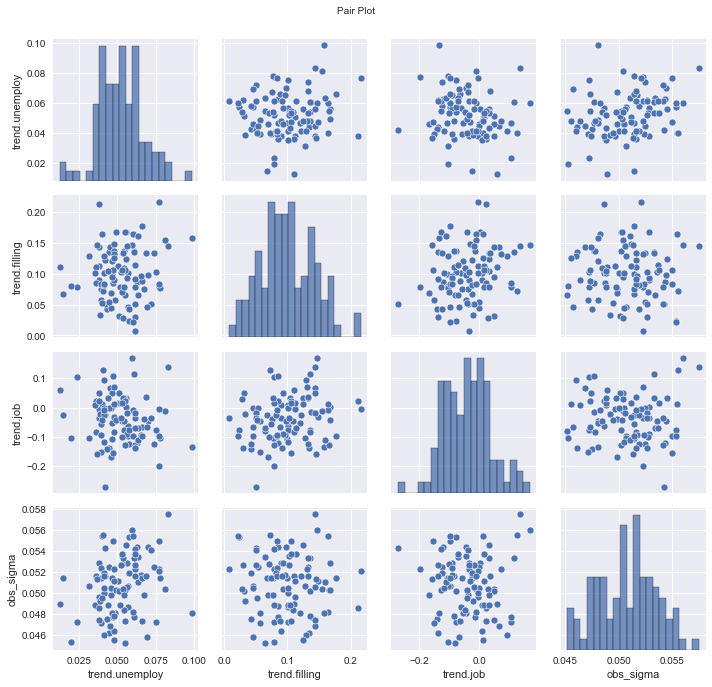

In [11]:
_ = plot_posterior_params(dlt_mcmc, kind='pair', pair_type='scatter', 
                          incl_trend_params=False, incl_smooth_params=False)

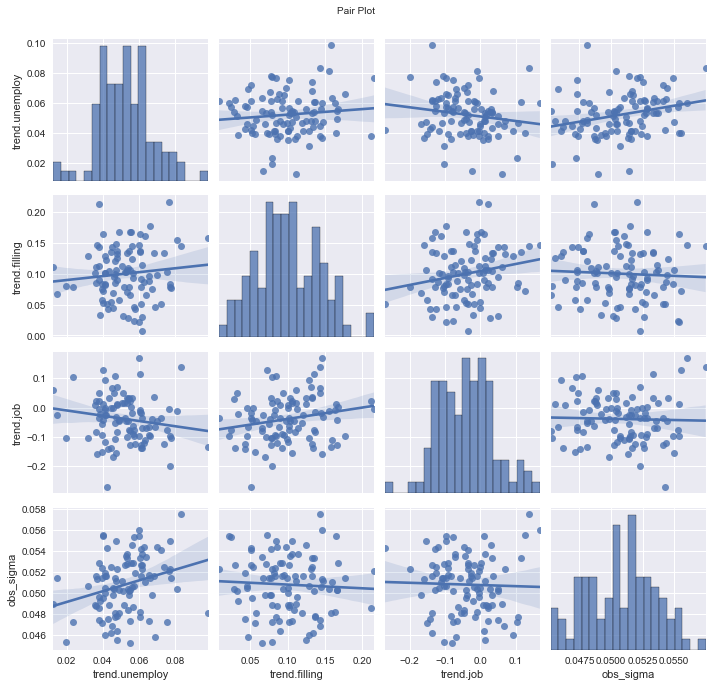

In [12]:
_ = plot_posterior_params(dlt_mcmc, kind='pair', pair_type='reg', 
                          incl_trend_params=False, incl_smooth_params=False)